# The Challenge
Previous work [1] has shown that LLMs memorize chunks of training data. This means that they reproduce text that they have seen in training. Obviosuly, this is unwanted especially in a business environment as reusing text produced by someone else and reproduced by the LLM can be a copyright infringement or plagiarism. Further, this limits the acceptance of using LLMs as business users have to fear that the prompts they give to the model are used for training the next generation and could then be reproduced by the model.

This is especially unfortunate in the realm of LLMs for coding assistance. It has been shown that AI coding assistants can significantly improve productivity [2]. However, code is often a valuable business resource and companies do not wish competitors to gain access to their implementations.

The goal of this coding challenge is, therefore, to conduct a preliminary investigation into whether LLMs trained on code are likely to reproduce code snippets from their training data. This will be done by comparing likelihoods of producing the exact code provided between code from the training data and previously unseen code.

## Load the model
To get started we implement functions to load the LLMs using Huggingface. For our investigation we will focus on the Starcoder [3] model, which is open source and can be found on [Hugging Face Hub](https://huggingface.co/bigcode/starcoderbase).

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import os

MAX_TOKENS = 10

def get_device() -> torch.device:
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def load_model(checkpoint: str, device: torch.device = None, token: str = None) -> tuple:
    if token == None:
        token = os.environ.get('HUGGINGFACE_KEY')
    if device == None:
        device = get_device()
    tokenizer = AutoTokenizer.from_pretrained(checkpoint, token=token)
    model = AutoModelForCausalLM.from_pretrained(checkpoint, token=token).to(device)
    model.eval()

    return tokenizer, model

Let's test the Starcoder model.

In [ ]:
# model_checkpoint = "bigcode/starcoderbase-1b"
model_checkpoint = "bigcode/starcoderbase-3b"
# model_checkpoint = "bigcode/starcoderbase-7b"
# model_checkpoint = "Salesforce/codegen2-3_7B"
device = get_device()
token = os.environ.get('HUGGINGFACE_KEY')

tokenizer, model = load_model(model_checkpoint, device, token)

In [4]:
FILL_INDICATOR = "<FILL>"
FIM_PREFIX = "<fim_prefix>"
FIM_MIDDLE = "<fim_middle>"
FIM_SUFFIX = "<fim_suffix>"

def code_filling(prompt: str, tokenizer, model, device) -> str:
    prefix, suffix = prompt.split(FILL_INDICATOR)
    prompt = f"{FIM_PREFIX}{prefix}{FIM_SUFFIX}{suffix}{FIM_MIDDLE}"

    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    outputs = model.generate(inputs, max_new_tokens=MAX_TOKENS)
    return outputs[0]

In [5]:
def continue_prompt(prompt: str, tokenizer, model, device) -> str:
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    outputs = model.generate(inputs, max_new_tokens=MAX_TOKENS, num_return_sequences=1)
    return outputs[0]

In [7]:
input_text = """def fibonacci(n):
  if n == 0 :
     return 1
  elif n == 1 :
     return 1
  else :
     a = 0
     b = 1
     <FILL>
     return b"""

result = code_filling(input_text, tokenizer, model, device)
print("Result:")
print(tokenizer.decode(result))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Result:
<fim_prefix>def fibonacci(n):
  if n == 0 :
     return 1
  elif n == 1 :
     return 1
  else :
     a = 0
     b = 1
     <fim_suffix>
     return b<fim_middle>
     for i in range(2, n)


In [8]:
input_text = """
def fibonacci(n):
    if n == 0 :
        return 1
"""

result = continue_prompt(input_text, tokenizer, model, device)
print("Result:")
print(tokenizer.decode(result))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Result:

def fibonacci(n):
    if n == 0 :
        return 1

print(fibonacci(10))



In [6]:
def continue_logits(prompt: str, tokenizer, model, device):
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)

    # Generate code continuation and retrieve logits
    with torch.no_grad():
        outputs = model(inputs, return_dict=True)
        logits = outputs.logits

    # Choose the next token based on logits (you can adjust the sampling strategy)
    next_token_index = torch.argmax(logits, dim=-1)
    print(next_token_index.size())

    # Decode the next token and append it to the existing code
    generated_code = tokenizer.decode(next_token_index[0])
    print(generated_code)
    return generated_code

In [10]:
result = continue_logits(input_text, tokenizer, model, device)

torch.Size([1, 19])

 testonacci(n):
    if n == 0:
        return 0
   



In general these results do not seem to indicate a good performance with the Starcoder-3b model (probably due to the relatively small model size). However, for our purposes we do not need a perfect prediction. We simply need the likelihoods to approximate the likelihoods of a perfect model to a reasonable degree. As the model produces code that is meaningful we assume this is the case.

## Likelihood
To compare the likelihood that a certain code is produced by the model, we have two options:

The easiest and most intuitive way to calculate the Likelihood would be to take an example code and cut it at an arbitrary position (e.g. half of the code). Then, we could use the model to generate the probability of the next *n* tokens and use the probabilty of the tokens that we cut off as the likelihood. However, this approach has two drawbacks. First, the position at which we cut off the code is arbitrary and could have a significant impact on model performance. Second, due to the masked self-attention mechanism and the auto-recusive behaviour of the Transformer model the prediction of the token t+1 depends on the prediction for the token t. Thus, if our model predicts an early token wrong all subsequent predictions will suffer.

Consequently, we opt for a different approach using token-wise likelihoods. We, thus, start with only the first token and predict the second one. We save the probability that this token is the expected token. Then, we use the first two tokens and predict the third one and so forth. Finally, we average the probabilities to form a overall Likelihood. This approach mitigates the previously mentioned issues.

In [7]:
import numpy as np
import torch.nn.functional as F

def predict_next_token(in_tokens, model, tokenizer) -> torch.tensor:
    with torch.no_grad():
        outputs = model(in_tokens.to(model.device), return_dict=True).logits

    if len(in_tokens.size()) < 3:
        return outputs[0]
    if len(in_tokens.size()) == 3:
        return outputs[:, 0, :]
    return None

def get_tokenwise_probabilities(code: str, model, tokenizer, device) -> np.array:
    tokens = tokenizer.encode(code, return_tensors="pt")
    probabilities = []
    for i in range(1, tokens.size(1)):
        res = predict_next_token(tokens[0][:i], model, tokenizer)
        res = res.cpu()
        probs = F.softmax(res, dim=-1)  # logits to pseudo-probability
        prob_correct = probs[tokens[0, i]].detach().cpu().numpy()
        probabilities.append(prob_correct)
    return np.array(probabilities)


def get_likelihood(code: str, model, tokenizer, device) -> float:
    tokenwise_probabilities = get_tokenwise_probabilities(code, model, tokenizer, device)
    return np.mean(tokenwise_probabilities)  # we use the mean as mutliplication would lead to smaller values for longer code

In [ ]:
example_code ="""def print_hello_world():
    print("Hello World")

  print_hello_world()
  """

get_likelihood(example_code, model, tokenizer, device)

This function seems to give a reasonable likelihood for a probably known piece of code. Let's compare it to zlib compression entropy.

## Zlib Entropy
Entropy is an expression of randomness of any input data. Using zlib, we can compress a string to a more concise representation. Thus, by calculating the entropy of the compressed code we can access the randomness of certain patterns in the code rather than the entropy of characters. This will give us a more accurate form of entropy that more closely resembles the true randomness of the code.

In [8]:
import zlib
import math

def calculate_shannon_entropy(data: bytes) -> float:
    byte_count = {}
    for byte in data:
        byte_count[byte] = byte_count.get(byte, 0) + 1
    probabilities = [count / len(data) for count in byte_count.values()]
    entropy = [prob * math.log2(prob) for prob in probabilities if prob > 0]
    entropy = -sum(entropy)
    return entropy

def calculate_zlib_entropy(code: str) -> float:
    compressed = zlib.compress(code.encode())

    return calculate_shannon_entropy(compressed)

In [14]:
calculate_zlib_entropy(example_code)

5.3676344862125935

The implementatioon seems to give a reasonable value for entropy. However, this value is hard to compare to the likelihood calculated before as it if not normalized to the [0, 1] range.

We know, that the maximal entropy for a byte array of length N is given by $$H_{max}(N) = -\sum_{i=1}^{N} \frac{1}{N} \cdot log_{2} \frac{1}{N} = -log_{2}\frac{1}{N}$$

Thus, we can normalize our entropy easily to range [0, 1]. Unfortunately, this value is still unintuitive as a high (normalized) entropy implies high unpredictability while a high likelihood implies a high predictability.

Therefore, we define a *zlib predictability score* (*z-score*) as:
$$ z\_score(x) = 1 - H_{normalized}(zlib.compress(x)) = 1 - \frac{H(zlib.compress(x))}{H_{max}(len(zlib.compress(x)))} $$

This should give a score that can intuitively be compared to likelihoods.

In [9]:
def get_max_zlib_entropy(code: str) -> float:
    compressed = zlib.compress(code.encode())
    N = len(compressed)

    return -math.log2(1/N)

def get_normalized_zlib_entropy(code: str) -> float:
    return calculate_zlib_entropy(code) / get_max_zlib_entropy(code)

def get_zlib_score(code: str) -> float:
    return 1 - get_normalized_zlib_entropy(code)

In [16]:
get_zlib_score(example_code)

0.07156192449748733

## Plotting
Finally, let's define utilities to plot the results from our models and the zlib score in a comparative bar chart.

We assume our input data is a numpy array of shape *num_models x num_prompts*.
Whereby, *num_models* is the number of different LLMs we want to test +1 for the zlib score.

In [10]:
import matplotlib.pyplot as plt

BAR_WIDTH = 0.35
BAR_GAP = 0.4
TEXT_GAP = 0.02
FONT_SIZE = 6

def plot_results(data: np.array, model_names: list, prompt_names: list):
    assert len(data.shape) == 2
    assert data.shape[1] == len(model_names)
    assert data.shape[0] == len(prompt_names)

    num_prompts, num_models = data.shape

    # each model get's its own color
    metric_colors = ['#a8dcd1', '#dce2c8', '#f17f29']

    set_positions = np.arange(num_prompts) * (num_models * (BAR_WIDTH + BAR_GAP))

    added_labels = []
    # we group results for prompts together
    for i in range(num_prompts):
        for j in range(num_models):
            label = model_names[j]
            # we only want to show the label once for each color
            if label not in added_labels:
                plt.bar(set_positions[i] + j * BAR_WIDTH, data[i, j], width=BAR_WIDTH, color=metric_colors[j], label=model_names[j])
                added_labels.append(label)
            else:
                plt.bar(set_positions[i] + j * BAR_WIDTH, data[i, j], width=BAR_WIDTH, color=metric_colors[j])
            # add text with exact value above bar
            plt.text(set_positions[i] + j * BAR_WIDTH, data[i, j] + TEXT_GAP, f'{data[i, j]:.2f}', ha='center', va='bottom', fontsize=FONT_SIZE)

    plt.ylabel('Likelihood in % / Entropy-score')
    plt.ylim(bottom=0, top=1)
    plt.title('Comparison Plot')
    plt.xticks(set_positions + (num_models - 1) * BAR_WIDTH / 2, prompt_names)
    plt.legend(loc='upper right')

    plt.show()

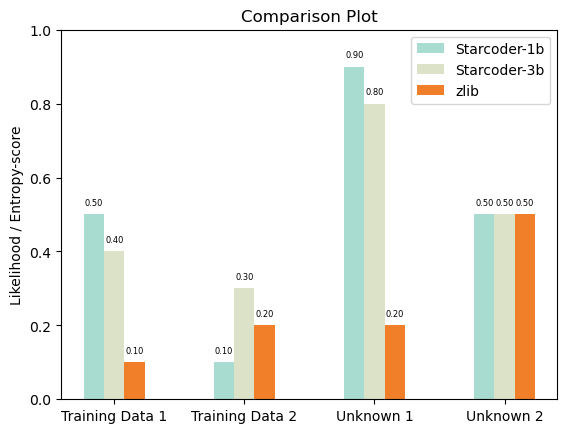

In [18]:
example_data = [[0.5, 0.4, 0.1], [0.1, 0.3, 0.2], [0.9, 0.8, 0.2], [0.5, 0.5, 0.5]]
example_data = np.array(example_data)
example_model_names = ['Starcoder-1b', 'Starcoder-3b', 'zlib']
example_prompt_names = ['Training Data 1', 'Training Data 2', 'Unknown 1', 'Unknown 2']
plot_results(example_data, example_model_names, example_prompt_names)

## The data
For a fair comparison we use 2 pieces of code from the training data and 2 pieces of code previously unseen by the models.

Unfortunately, [Starcoder Search](https://huggingface.co/spaces/bigcode/search) is currently unavailable. However, we used the search function for [The Stack Smol](https://huggingface.co/datasets/bigcode/the-stack-smol) (same data as the large dataset but only for few programming languages) to find implementations the model was trained on.

For the previously unseen data we used code from [my GitHub](https://github.com/ragor114/). According to [Am I in The Stack](https://huggingface.co/spaces/bigcode/in-the-stack) my code was not used for the dataset. Further, we tried to verify that no almost identical code is in The Stack using the search for The Stack Smol.

While we cannot confirm with absolute certainty, that the unseen code is sufficiently different from previously seen data, we feel confident enough in this hypothesis for the current analysis.

Further, we use Python and JavaScript code to mitigate effects induced by the specific programming language.

In [11]:
KNOWN_PROMPT_PYTHON = """indent = 10 # How many spaces to indent.
while True:
    print(' ' * indent, end='')
    bext.fg('red')
    print('##', end='')
    bext.fg('yellow')
    print('##', end='')
    bext.fg('green')
    print('##', end='')
    bext.fg('blue')
    print('##', end='')
    bext.fg('cyan')
    print('##', end='')
    bext.fg('purple')
    print('##')
    """

KNOWN_PROMPT_JS = """var editable=false;
function makeEditable() {
    editable = !editable;
    if(editable) {
        $$('.actual_button').invoke('disable');
        $$('.new_button').invoke('show');
        $$('.skip_button').invoke('hide');
        $$('.edit_button').invoke('show');
        $$('.delete_button').invoke('show');
    } else {
        $$('.actual_button').invoke('enable');
        hideBucketForm();
        $$('.new_button').invoke('hide');
        $$('.skip_button').invoke('show');
        $$('.edit_button').invoke('hide');
        $$('.delete_button').invoke('hide');
    }
}"""

UNKNOWN_PROMPT_PYTHON = """def simplified_kernel(x, mean, bandwidth=1):
    distances = np.linalg.norm(x - mean, axis=1)
    kernel_values = np.zeros_like(distances)

    kernel_values[distances < bandwidth] = -1 / bandwidth ** 2 * distances[distances < bandwidth] ** 2 + 1

    return kernel_values, distances"""

UNKNOWN_PROMPT_JS = """function handleAutoplayError() {
  let button = document.createElement("button"),
    background = document.createElement("div");

  button.innerHTML = "Click here to resume round";
  button.classList.add("errorButton");
  background.classList.add("error-background");

  button.addEventListener("click", function() {
    button.classList.add("hidden");
    background.classList.add("hidden");
    player.resume();
  });
}"""

prompts = [KNOWN_PROMPT_PYTHON, KNOWN_PROMPT_JS, UNKNOWN_PROMPT_PYTHON, UNKNOWN_PROMPT_JS]
prompt_names = ['Known Python', 'Known JS', 'Unknown Python', 'Unknown JS']

## Experiment
Finally, we bring it all together. For our experiment we use two models of similar architecture. To verify, whether large models are actually more likely to memorize training data as suspected by [1], we use one model with 1 billion and another model with 3 billion parameters. While testing a larger model could reveal interesting results our compute for these experiments is extremely limited. We decide to use StarCoder-1B and Starcoder-3B [3]. Both models were trained on the The Stack dataset [4]. Thus, code unseen to one model is also unseen to the other and vice versa.

In [12]:
def get_values_for_model(prompts: list, model_name: str) -> list:
    if model_name == 'zlib':
        results = [get_zlib_score(p) for p in prompts]
        return results
    device = get_device()
    tokenizer, model = load_model(model_name, device)
    result = [get_likelihood(p, model, tokenizer, device) *100 for p in prompts]
    return result

def experiment(prompts: list, prompt_names: list, models: list, model_names: list):
    assert len(prompts) == len(prompt_names)
    assert len(models) == len(model_names)

    result = [[] for _ in prompts]
    for model in models:
        curr_result = get_values_for_model(prompts, model)
        for j, res in enumerate(curr_result):
            result[j].append(res)
    result = np.array(result)

    plot_results(result, model_names, prompt_names)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/export/home/ra37rok/miniconda3/envs/weather_vae/lib/python3.11/site-packages/transformers/utils/hub.py:373: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


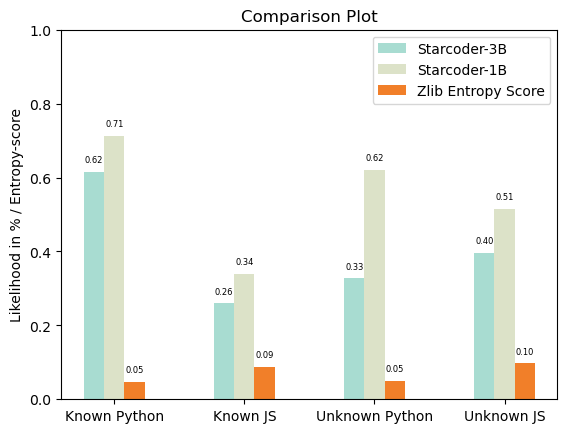

In [13]:
models = [
    'bigcode/starcoderbase-3b',
    'bigcode/starcoderbase-1b',
    'zlib'
]
model_names = [
    'Starcoder-3B',
    'Starcoder-1B',
    'Zlib Entropy Score'
]

experiment(prompts, prompt_names, models, model_names)

## Results and Interpretation
Unfortunately, our results are inconclusive. Manually inspecting the likelihoods it seems like for the Python code our hypothesis, that the likelihood is higher for code from the training data, holds. Conversely, for the JavaScript code the opposite seems to be the case. It should be mentioned, however, that the entropy score for the known JavaScript code is a bit lower than for the unknown JavaScript. This hints at a higher inherent randomness in the known JavaScript code than in the unknown JavaScript code. The entropy for known and unknown python on the other hand appear very similar.

Further, we could not verify the claim that larger models are more prown to reproduce the training data [1]. While the difference between the likelihoods for known and unknown python code are larger for the model with 3B parameters than for the model with only 1B parameters (0.29 vs. 0.09) for some reason the likelihoods are in general higher for the 1B parameter model which limits the conclusions we can draw from this observation and requires further investigation.

In addition, the likelihoods we observed are pretty low overall. This could be due to the non-linear properties of the Softmax function, exaggarating the maximal value und suppressing the lower values. It could also indicate that we did not use the special tokens of these models correctly. In the best case, however, this indicates that it is not very likely to extract training data from the Code LLMs.

In summary, our preliminary results leave a lot of room for further investigation. While we did observe initial evidence that Code LLMs might reproduce the training data (here for the Python code) these findings are called into question by other examples (the JavaScript code).

### Next Steps
To further validate the initial hypothesis several steps should be taken next

*   Test with even larger models: Previous work [4] seems to suggest that larger models are even more vulnerable to extraction attacks. Therefore, furture research should test even larger LLMs with more than 3B parameters. However, due to limits in compute this could not be done here.
*   Are differences actually due to training data: In our current experiment, the differences could also simply stem from the different types of code used. We should test our hypothesis using a model where the code was part of the training data and where it was not. This could be achieved by finetuning the models on a small dataset including the previously unseen code snippets.
*   Test with models trained on different datasets: The current models have both been trained on the same data and the results should be verified using models trained on different data.
*   Conduct extensive test with inferential statistics: While manual inspection can give a first insight, a study using inferential statistics should be conducted to verify statistical significance.
*   Repeat for chat-based coding assistants: Many of the coding assistants used today are Chat-based. Consequently, the study should be adapted and conducted for chat-based systems.

## References
[1] Carlini, N., Tramèr, F., Wallace, E., Jagielski, M., Herbert-Voss, A., Lee, K., Roberts, A., Brown, T., Song, D., Erlingsson, Ú., Oprea, A., & Raffel, C. (2020). Extracting Training Data from Large Language Models. arXiv (Cornell University). https://doi.org/10.48550/arxiv.2012.07805

[2] Peng, S., Kalliamvakou, E., Cihon, P., & Demirer, M. (2023). The Impact of AI on Developer Productivity: Evidence from GitHub Copilot. arXiv (Cornell University). https://doi.org/10.48550/arxiv.2302.06590

[3] Li, R., Allal, L. B., Zi, Y., Muennighoff, N., Kocetkov, D., Mou, C., Marone, M., Akiki, C., Li, J., Chim, J., Liu, Q., Zheltonozhskii, E., Zhuo, T. Y., Wang, T. J., Dehaene, O., Davaadorj, M., Lamy-Poirier, J., Monteiro, J. L., Shliazhko, O., . . . De Vries, H. (2023). StarCoder: may the source be with you! arXiv (Cornell University). https://doi.org/10.48550/arxiv.2305.06161

[4] Kocetkov, D., Li, R., Allal, L. B., Li, J., Mou, C., Ferrandis, C. M., Jernite, Y., Mitchell, M., Hughes, S., Wolf, T., Bahdanau, D., Von Werra, L., & De Vries, H. (2022). The Stack: 3 TB of permissively licensed source code. arXiv (Cornell University). https://doi.org/10.48550/arxiv.2211.15533

